<a href="https://colab.research.google.com/github/stephenbaek/dlcourse/blob/main/assignments/a2_mnist.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

# Project Proposal

The goal is to take images (here I'm using a small sample of 40) that show five letters and/or numbers, along with labels showing the true values of those five letters/numbers, and prepare them to be fed into a deep learning framework. Due to the nature of this problem, I don't know exactly how the data will need to be transformed, so I simply perform some basic tasks (importing images and labels, creating a dataset, normalizing the pixel values, and standardizing the size) that I am sure will be important.

##Import necessary modules

In [1]:
import tensorflow as tf
import pathlib
import os
import numpy as np
import matplotlib.pyplot as plt

##Get sample data

In [2]:
#Get the data from my GitHub repository.
#This will throw a message "fatal: destination path 'ISE6380' already exists and is not an empty directory."
#if it is run two or more times. It does not affect the execution of any other code within this cell. 
#It can be commented out after the first time running this cell.
!git clone https://github.com/JonathonHowland/ISE6380

#Get the file names and files
names = tf.data.Dataset.list_files("/content/ISE6380/Sample/*.jpg", shuffle=False)
images = names.map(lambda x: tf.io.decode_jpeg(tf.io.read_file(x)))

#Check to make sure that all 40 names and images were obtained
print(len(images))
print(len(names))

fatal: destination path 'ISE6380' already exists and is not an empty directory.
40
40


###The names contain the full file path, where we just want the file name.

In [3]:
#We need the names as a list
nameList = list(names.as_numpy_iterator())
print(nameList)

#They're messy, so let's clean them up.
newNameList = []

for n in nameList:
  string = str(n)
  temp = string.split("/")[-1]
  newName = temp.split(".")[0]
  newNameList.append(newName)

#Much better
print(newNameList)

[b'/content/ISE6380/Sample/1A19j.jpg', b'/content/ISE6380/Sample/1A5b9.jpg', b'/content/ISE6380/Sample/1A5bZ.jpg', b'/content/ISE6380/Sample/1A6HY.jpg', b'/content/ISE6380/Sample/1A7ug.jpg', b'/content/ISE6380/Sample/1A8u5.jpg', b'/content/ISE6380/Sample/1AEKj.jpg', b'/content/ISE6380/Sample/1AG88.jpg', b'/content/ISE6380/Sample/1AH18.jpg', b'/content/ISE6380/Sample/1AHAP.jpg', b'/content/ISE6380/Sample/1AHJZ.jpg', b'/content/ISE6380/Sample/1Aagu.jpg', b'/content/ISE6380/Sample/1AbEm.jpg', b'/content/ISE6380/Sample/1Ac1z.jpg', b'/content/ISE6380/Sample/1Ad8L.jpg', b'/content/ISE6380/Sample/1AdwW.jpg', b'/content/ISE6380/Sample/1Afwl.jpg', b'/content/ISE6380/Sample/1AhmT.jpg', b'/content/ISE6380/Sample/1AiQZ.jpg', b'/content/ISE6380/Sample/1a1SZ.jpg', b'/content/ISE6380/Sample/1a2BM.jpg', b'/content/ISE6380/Sample/1a3Us.jpg', b'/content/ISE6380/Sample/1a43P.jpg', b'/content/ISE6380/Sample/1a4lr.jpg', b'/content/ISE6380/Sample/1a4pv.jpg', b'/content/ISE6380/Sample/1a6QN.jpg', b'/content/

##Create dataset of images and labels

In [13]:
nameDs = tf.data.Dataset.from_tensor_slices(newNameList)

#Make the dataset
total_ds = tf.data.Dataset.zip((images, nameDs))

#Split it into training and test data
total_ds = total_ds.shuffle(len(total_ds))
train_ds = total_ds.take(int(0.8*len(total_ds)))
test_ds = total_ds.skip(int(0.8*len(total_ds)))

### Check to make sure images and labels are correct

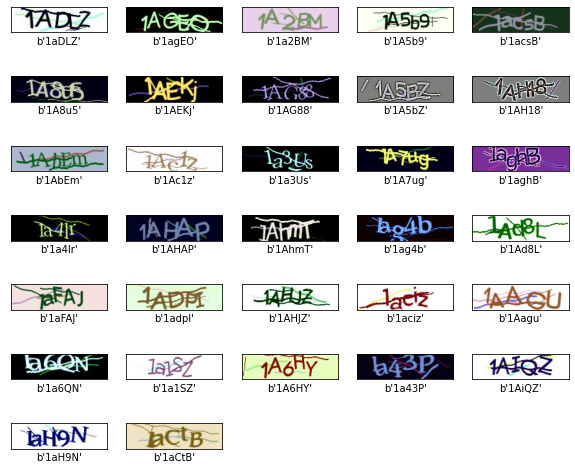

In [14]:
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(train_ds):
    plt.subplot(8,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label.numpy())
plt.show()

###Normalize the pixel values between -1 and 1

In [6]:
def normalize(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = (image - 127.5)/127.5
  print(tf.reduce_max(image))
  return image, label

### One-hot encoding

I'm not really sure how to do this for my problem (or even if it's necessary), but here's the basic idea behind what I want to do.

I want each "label" to be a capital letter, lowercase letter, or number (0-9). So, my one-hot encoding will have 62 possible values (26x2 letters + 10 numbers). I'm not going to use this function yet, but I imagine this is similar to what I will need to do.

In [7]:
def one_hot(image, label):
  label = tf.one_hot(label, 62, on_value=1.0, off_value=0.0)
  return image, label

###Resize the images

In [8]:
#From what I can see, the images are already all 40x150 pixels, but it doesn't hurt to make sure
def resize(image, label):
  image = tf.image.resize(image, [40,150])
  return image, label

###Apply the preprocessing functions. This is more to get an idea of what I will do. I will probably use layers to accomplish this in the final project.

In [11]:
train_ds=train_ds.map(normalize)
train_ds=train_ds.map(resize)
test_ds=test_ds.map(normalize)
test_ds=test_ds.map(resize)

<BatchDataset shapes: ((None, 40, 150, None), (None,)), types: (tf.float32, tf.string)>
Tensor("Max:0", shape=(), dtype=float32)
<MapDataset shapes: ((None, 40, 150, None), (None,)), types: (tf.float32, tf.string)>


###Make batches.

In [15]:
train_ds=train_ds.shuffle(len(train_ds))
train_ds=train_ds.batch(8)
test_ds=test_ds.batch(8)

###The data should now be more or less ready to feed into a machine learning model.